In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [2]:
%matplotlib inline

from session.sessions import selected_009266, selected_008229, selected_009265
from imports import *
from scipy import stats
from scipy import signal
from sklearn import decomposition
from sklearn.cluster import DBSCAN
from behavior import get_extent, density_map, get_idxs_behav_state
from spatial import gaussian_kernel_2D, get_field_patches

from population import unit_response_matrix, activity_at_phase

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [7]:
source = '/home/sobolev/nevermind_ag-grothe/AG_Pecka/data/processed/'
source = '/home/sobolev/nevermind/AG_Pecka/data/processed/'

sessions = [s for s in selected_009266.keys()]
sessions = [s for s in selected_009265.keys()]
#sessions = [s for s in selected_008229.keys()]
sessions.sort()

selected = sessions[:]
try:
    selected.remove('009266_hippoSIT_2023-04-20_15-24-14')
except:
    pass
try:
    selected.remove('009265_hippoSIT_2023-02-27_10-18-32')
    selected.remove('009265_hippoSIT_2023-02-27_15-33-46')
except:
    pass
selected

['009265_hippoSIT_2023-02-24_09-53-26',
 '009265_hippoSIT_2023-02-24_17-22-46',
 '009265_hippoSIT_2023-02-28_09-16-50',
 '009265_hippoSIT_2023-02-28_13-16-10',
 '009265_hippoSIT_2023-02-28_20-45-04',
 '009265_hippoSIT_2023-03-01_10-46-12',
 '009265_hippoSIT_2023-03-02_09-32-54',
 '009265_hippoSIT_2023-03-02_16-27-42',
 '009265_hippoSIT_2023-03-02_20-11-35',
 '009265_hippoSIT_2023-03-03_09-37-07',
 '009265_hippoSIT_2023-03-03_16-00-47',
 '009265_hippoSIT_2023-03-04_11-12-04',
 '009265_hippoSIT_2023-03-05_11-52-17',
 '009265_hippoSIT_2023-03-05_18-31-32',
 '009265_hippoSIT_2023-03-08_18-10-07',
 '009265_hippoSIT_2023-03-09_20-03-08',
 '009265_hippoSIT_2023-03-10_09-57-34',
 '009265_hippoSIT_2023-04-13_09-54-39',
 '009265_hippoSIT_2023-04-20_11-39-02']

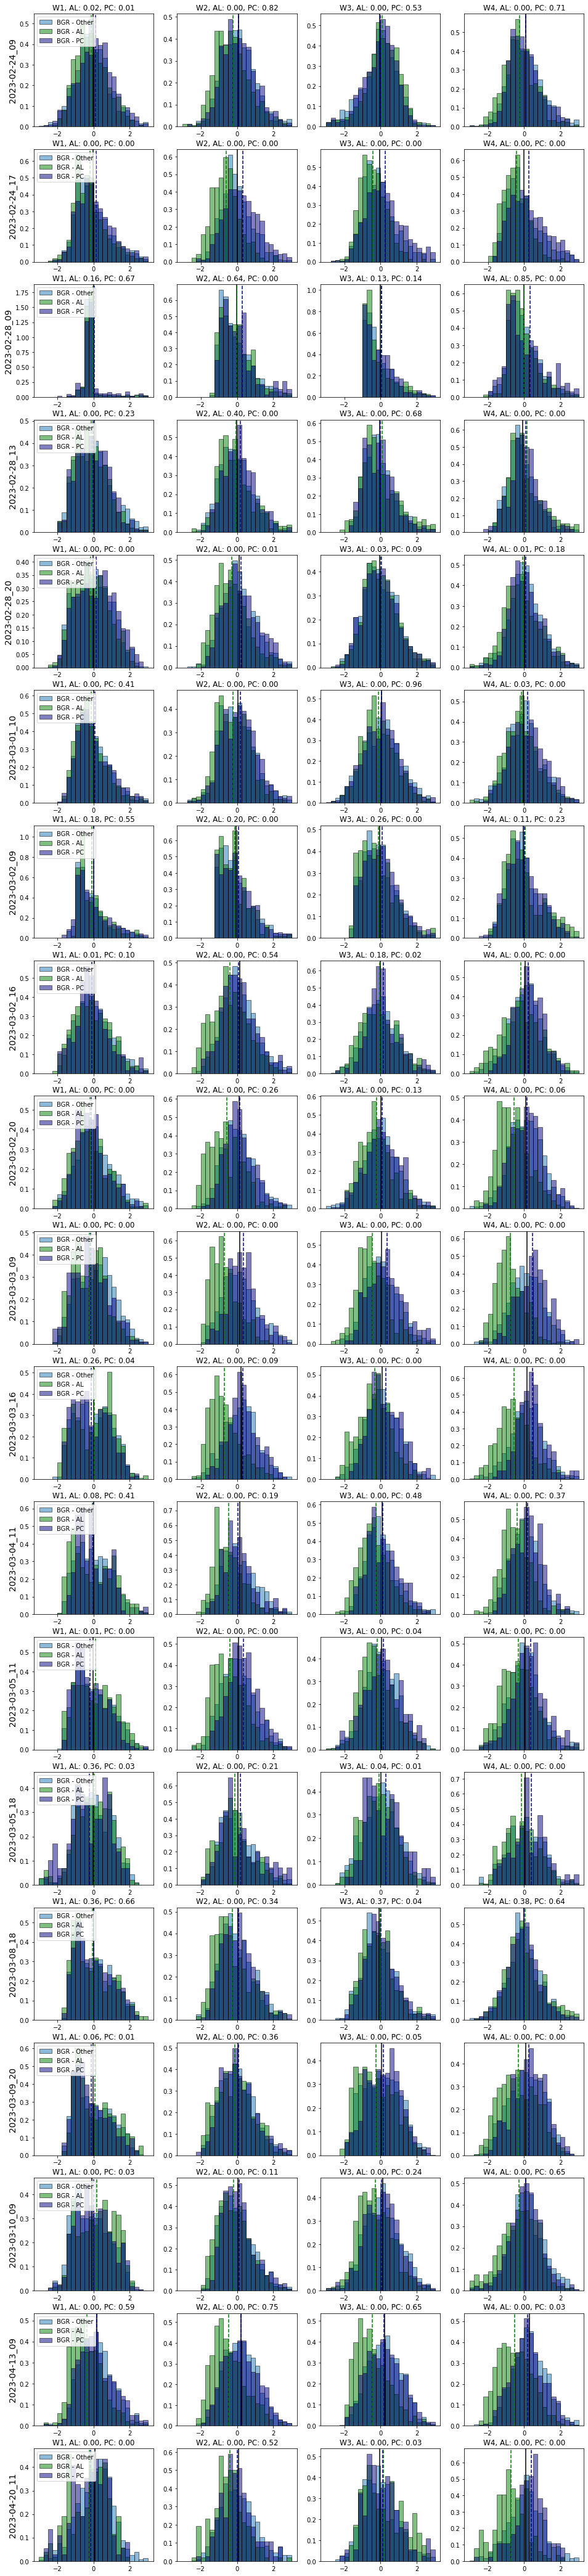

In [8]:
ft = 'tSNE'
fp = 70
#ft = 'UMAP'
#fp = 0.5
exp_states = {'SIL': 0, 'BGR': 1, 'TGT': 2}
width = 70  # 100 points ~= 1 sec with at 100Hz
kernel = signal.gaussian(width, std=(width) / 7.2)

exp_state = 'BGR'
rows = len(selected)
cols = 4
size = 4
fig, axes = plt.subplots(rows, cols, figsize=(size*cols, size*rows))

w_stats = {}
for i, session in enumerate(selected):
    animal = session.split('_')[0]
    s_path           = os.path.join(source, animal, session)
    meta_file        = os.path.join(source, animal, session, 'meta.h5')
    moseq_file       = os.path.join(source, animal, session, 'MoSeq.h5')
    moseq_class_file = os.path.join(source, animal, session, 'analysis', 'MoSeq_tSNE_UMAP.h5')
    
    with h5py.File(meta_file, 'r') as f:
        tl = np.array(f['processed']['timeline'])
        tgt_mx = np.array(f['processed']['target_matrix'])
        events = np.array(f['processed']['sound_events'])
    with h5py.File(moseq_class_file, 'r') as f:
        idxs_srm_tl = np.array(f['idxs_srm_tl'])
        fit = np.array(f[ft][str(fp)])
    with h5py.File(moseq_file, 'r') as f:
        moseq = np.array(f['moseq'])

    # speed to filter out
    dx = np.sqrt(np.square(np.diff(moseq[:, 3])) + np.square(np.diff(moseq[:, 4])))
    dt = np.diff(moseq[:, 0])
    speed = np.concatenate([dx/dt, [dx[-1]/dt[-1]]])
    speed_smooth = np.convolve(speed, kernel, 'same') / kernel.sum()

    idxs_idle = np.where(speed_smooth < 10.04)[0]  # define speed filter here
    state_id  = exp_states[exp_state]
    idxs_srm_state = np.where(tl[idxs_srm_tl][:, 6] == state_id)[0]
    idxs_srm_state = np.intersect1d(idxs_idle, idxs_srm_state)

    # state samples
    idxs_tl_tgt_succ = []
    idxs_tl_pellet   = []
    for tgt_rec in tgt_mx[tgt_mx[:, 4] == 1]:
        idxs_tl_tgt_succ += list(range(tgt_rec[2], tgt_rec[3]))
        idxs_tl_pellet   += list(range(tgt_rec[3] + 1*100, tgt_rec[3] + 6*100))
    idxs_tl_tgt_succ = np.array(idxs_tl_tgt_succ)
    idxs_tl_pellet   = np.array(idxs_tl_pellet)
    
    idxs_AL_tl = get_idxs_behav_state(source, session, idxs_tl_tgt_succ, fit_type=ft, fit_parm=fp, sigma=0.3, margin=10, bin_count=100)
    idxs_PC_tl = get_idxs_behav_state(source, session, idxs_tl_pellet, fit_type=ft, fit_parm=fp, sigma=0.3, margin=10, bin_count=100)

    idxs_AL = np.array([k for k, x in enumerate(idxs_srm_tl) if x in idxs_AL_tl], dtype=np.int32)
    idxs_PC = np.array([k for k, x in enumerate(idxs_srm_tl) if x in idxs_PC_tl], dtype=np.int32)
    
    idxs_AL_state = np.intersect1d(idxs_srm_state, idxs_AL)
    idxs_PC_state = np.intersect1d(idxs_srm_state, idxs_PC)
    idxs_out = np.setdiff1d(idxs_srm_state, idxs_AL)
    idxs_out = np.setdiff1d(idxs_out, idxs_PC)
    
    w_stats[session] = {}
    bins     = np.linspace(-3, 3, 25)
    for j, phase in enumerate([1, 2, 3, 4]):
        w_pca = activity_at_phase(s_path, phase, do_pca=True)
        w_int = np.interp(tl[idxs_srm_tl][:, 0], events[:, 0], w_pca)
        tt_AL = stats.ttest_ind(w_int[idxs_AL_state], w_int[idxs_out])
        tt_PC = stats.ttest_ind(w_int[idxs_PC_state], w_int[idxs_out])

        density = True
        state_mean, state_std = w_int[idxs_srm_state].mean(), w_int[idxs_srm_state].std()
        Y_out = (w_int[idxs_out] - state_mean)/state_std
        Y_AL  = (w_int[idxs_AL_state] - state_mean)/state_std
        Y_PC  = (w_int[idxs_PC_state] - state_mean)/state_std
        
        ax = axes[i][j]
        ax.hist(Y_out, bins=bins, edgecolor='black', alpha=0.5, density=density, color='tab:blue', label=exp_state + ' - Other')
        ax.hist(Y_AL,  bins=bins, edgecolor='black', alpha=0.5, density=density, color='green', label=exp_state + ' - AL')
        ax.hist(Y_PC,  bins=bins, edgecolor='black', alpha=0.5, density=density, color='navy', label=exp_state + ' - PC')
        ax.axvline(Y_out.mean(), color='black')
        ax.axvline(Y_AL.mean(),  color='green', ls='--')
        ax.axvline(Y_PC.mean(),  color='navy', ls='--')
        ax.set_title("W%s, AL: %.2f, PC: %.2f" % (j+1, tt_AL.pvalue, tt_PC.pvalue))
        if j == 0:
            ax.set_ylabel(session[-19:-6], fontsize=14)
            ax.legend(loc='upper left')
        
        w_stats[session][phase] = {}
        w_stats[session][phase]['out'] = Y_out
        w_stats[session][phase]['AL'] = Y_AL
        w_stats[session][phase]['PC'] = Y_PC
            

## Cross-session stats

In [9]:
sessions_009266 = [s for s in selected_009266.keys()]
sessions_009266.remove('009266_hippoSIT_2023-04-20_15-24-14')
sessions_009265 = [s for s in selected_009265.keys()][-11:]  # already filtered by A1 units and performance
sessions_009266.sort()
sessions_009265.sort()

selected = sessions_009265[:]
selected

['009265_hippoSIT_2023-03-02_20-11-35',
 '009265_hippoSIT_2023-03-03_09-37-07',
 '009265_hippoSIT_2023-03-03_16-00-47',
 '009265_hippoSIT_2023-03-04_11-12-04',
 '009265_hippoSIT_2023-03-05_11-52-17',
 '009265_hippoSIT_2023-03-05_18-31-32',
 '009265_hippoSIT_2023-03-08_18-10-07',
 '009265_hippoSIT_2023-03-09_20-03-08',
 '009265_hippoSIT_2023-03-10_09-57-34',
 '009265_hippoSIT_2023-04-13_09-54-39',
 '009265_hippoSIT_2023-04-20_11-39-02']

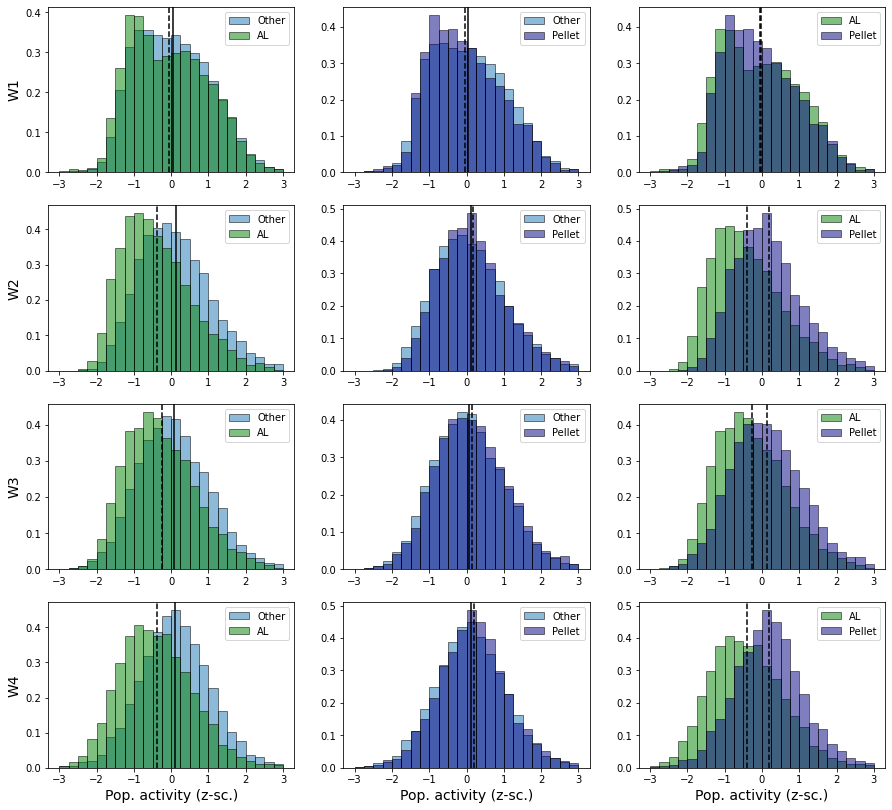

In [10]:
phases = [1, 2, 3, 4]
bins = np.linspace(-3, 3, 25)
density = True
colors = ['tab:blue', 'green', 'navy']
labels = ['Other', 'AL', 'Pellet']
rows = len(phases)

fig, axes = plt.subplots(rows, 3, figsize=(15, 3.5*rows))
for j, phase in enumerate(phases):
    w_other, w_AL, w_PC = [], [], []
    for session in selected:
        w_other += list(w_stats[session][phase]['out'])
        w_AL    += list(w_stats[session][phase]['AL'])
        w_PC    += list(w_stats[session][phase]['PC'])
    w_other, w_AL, w_PC = np.array(w_other), np.array(w_AL), np.array(w_PC)
    data = [w_other, w_AL, w_PC]

    for i, pair in enumerate([[0, 1], [0, 2], [1, 2]]):
        ax = axes[j][i]
        ax.hist(data[pair[0]], bins=bins, edgecolor='black', alpha=0.5, density=density, color=colors[pair[0]], label=labels[pair[0]])
        ax.hist(data[pair[1]], bins=bins, edgecolor='black', alpha=0.5, density=density, color=colors[pair[1]], label=labels[pair[1]])
        ax.axvline(data[pair[0]].mean(), color='black', ls='--' if pair[0] > 0 else '-')
        ax.axvline(data[pair[1]].mean(), color='black', ls='--' if pair[1] > 0 else '-')
        if j == len(phases) - 1:
            ax.set_xlabel('Pop. activity (z-sc.)', fontsize=14)
        if i == 0:
            ax.set_ylabel('W%d' % phase, fontsize=14)
        ax.legend(loc='upper right')